# Распознавание действий на видео с использованием VideoSwin Transformer

Данный проект реализует пайплайн по обучению, тестированию и инференсу модели распознавания действий на видео с использованием архитектуры **VideoSwin Transformer**. Модель обучена на датасете **HMDB51** и доступна в форматах `.pth` и `.onnx`.

Целью проекта являлась разработка модели для распознавания действий на видео, обеспечивающей высокую точность предсказаний.

Основные задачи:
    
- выбор архитектуры
- подготовка и предобработка видеоданных
- обучение и оценка качества модели
- реализация веб-интерфейса


## Импорт модулей

In [1]:
from pathlib import Path
import json
from collections import deque
import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr

ort.preload_dlls()

from video_module.utils import split_and_copy, save_obj_names, get_obj_names
from video_module.dataset import get_label_distribution
from video_module.trainer import train
from video_module.tester import VideoTester
from video_module.models import convert_to_onnx
from video_module.inference import process_video_onnx

c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Разделение датасета

In [2]:
SPLIT = False

if SPLIT:
    split_and_copy(
        Path("hmdb51_org"),
        Path("hmdb51_data"),
        splits={"train": 0.7, "val": 0.2, "test": 0.1},
    )

## Подсчет распределения меток по классам для видео датасета

Видеофайлы делились на клипы методом скользящего окна.

Dataset Initialisation: 4714it [01:17, 60.55it/s]


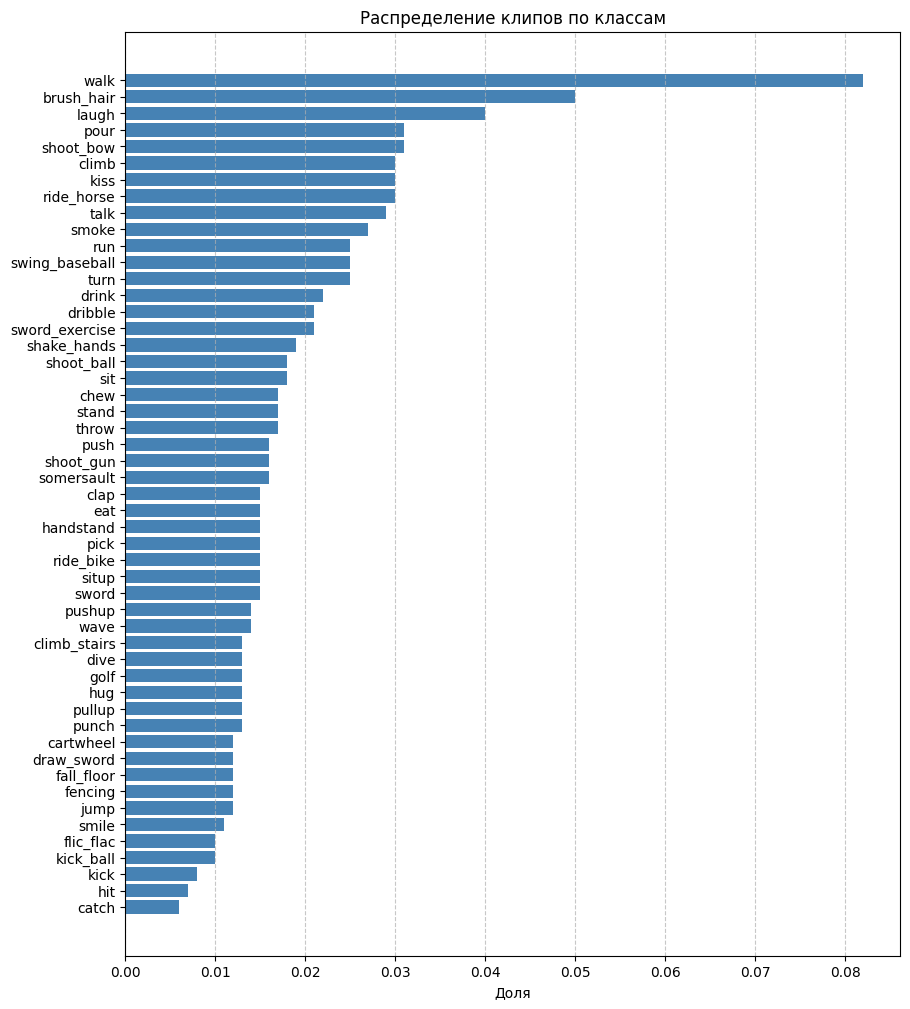

In [3]:
data = get_label_distribution(
    "hmdb51_data/train",
    obj_names="obj.names",
    clip_len=32,
    step=16,
    normalize=True,
)

with open("label_distribution_train_norm.json", "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)


def show_barh(data_path, key=None, title=None, xlabel=None):
    with open(data_path, "r") as f:
        data = json.load(f)
        if key:
            data = data[key]

    sorted_items = sorted(data.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)

    plt.figure(figsize=(10, 12))
    plt.barh(labels, values, color="steelblue")
    plt.xlabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()


show_barh(
    "label_distribution_train_norm.json",
    title="Распределение клипов по классам",
    xlabel="Доля",
)

## Обучение модели распознавания действий

Обучение модели занимало 5 дней с использованием видеокарты NVIDIA RTX 4060Ti (16 Gb).

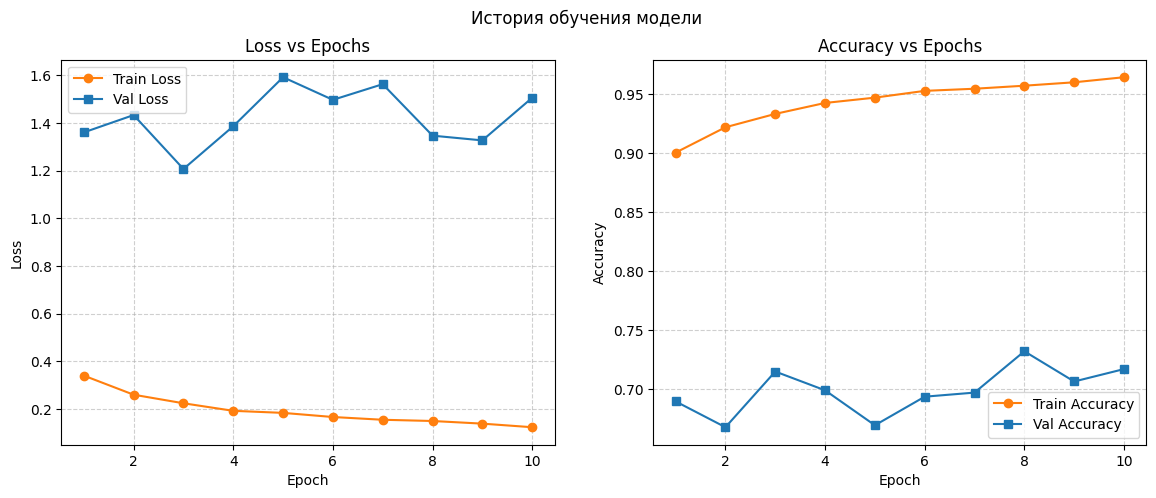

In [4]:
TRAIN = False

if TRAIN:
    save_obj_names(
        "hmdb51_data/train/",
        output_file="obj.names",
    )

    train(
        "hmdb51_data/train/",
        "hmdb51_data/val/",
        model_type="swin3d_b",
        save_path="swin3d_b.pth",
        checkpoint=None,
        obj_names="obj.names",
        img_size=224,
        num_epochs=10,
        batch_size=2,
        clip_len=32,
        step=16,
        lr=1e-4,
    )

with open("swin3d_b_logs.json", "r") as f:
    metrics = json.load(f)

train_loss = metrics["train_loss"]
val_loss = metrics["val_loss"]
train_acc = metrics["train_accuracy"]
val_acc = metrics["val_accuracy"]
epochs = list(range(1, len(train_loss) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss vs Epochs
ax1.plot(epochs, train_loss, marker="o", label="Train Loss", color="tab:orange")
ax1.plot(epochs, val_loss, marker="s", label="Val Loss", color="tab:blue")
ax1.set_title("Loss vs Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True, linestyle="--", alpha=0.6)
ax1.legend()

# Accuracy vs Epochs
ax2.plot(epochs, train_acc, marker="o", label="Train Accuracy", color="tab:orange")
ax2.plot(epochs, val_acc, marker="s", label="Val Accuracy", color="tab:blue")
ax2.set_title("Accuracy vs Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True, linestyle="--", alpha=0.6)
ax2.legend()

fig.suptitle("История обучения модели")
plt.show()

## Оценка точности модели на тестовой выборке

Dataset Initialisation: 719it [00:11, 61.59it/s]


Results are saved!
Average accuracy: 0.7391


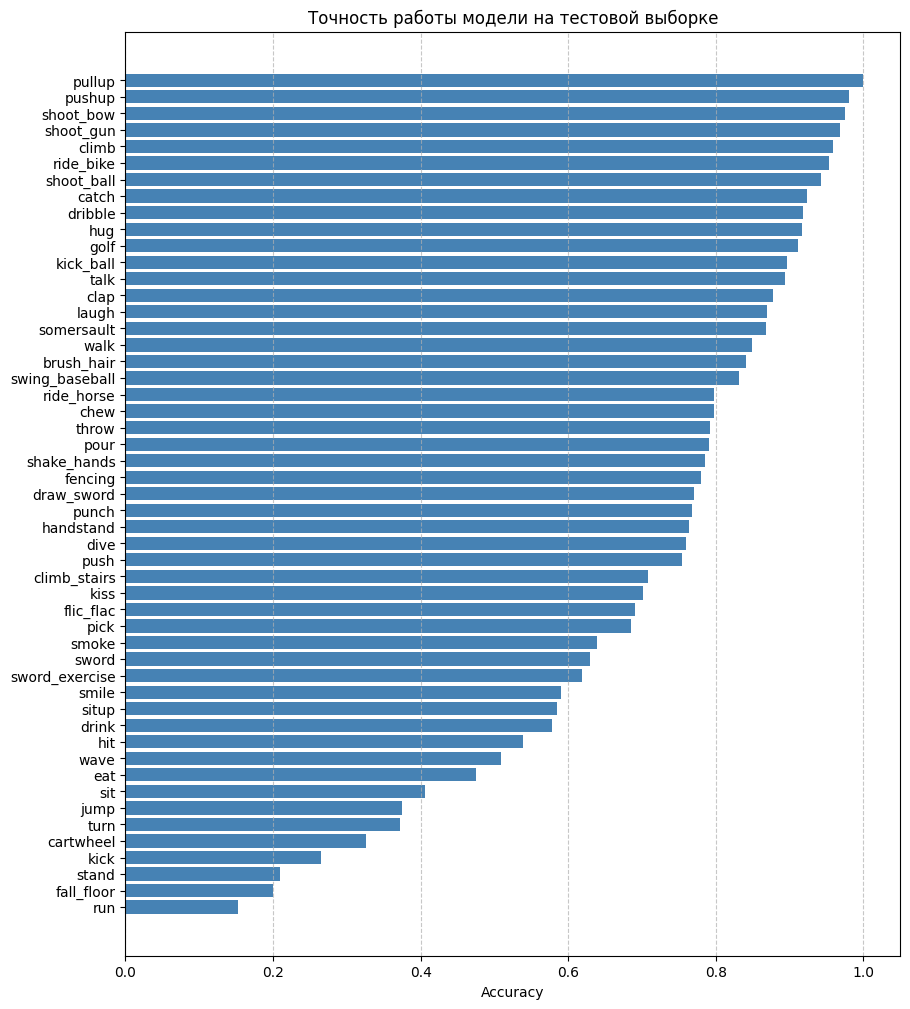

In [5]:
VideoTester(
    "hmdb51_data/test/",
    model_type="swin3d_b",
    checkpoint="swin3d_b.pth",
    obj_names="obj.names",
    batch_size=2,
    clip_len=32,
    step=16,
    img_size=224,
).test()

show_barh(
    "swin3d_b_results.json",
    key="per_class_accuracy",
    title="Точность работы модели на тестовой выборке",
    xlabel="Accuracy",
)

Средняя accuracy по датасету достигает 74%, однако для некоторых видов действий accuracy может быть ниже среднего значения.

## Конвертация модели из `.pth` в `.onnx`

In [6]:
convert_to_onnx(model_type="swin3d_b", obj_names="obj.names", checkpoint="swin3d_b.pth")

Model is converted to ONNX!


## Запуск инференса модели на видеоролике

In [7]:
process_video_onnx(
    "brushing_hair.avi",
    "swin3d_b.onnx",
    obj_names="obj.names",
    clip_len=32,
    skip_frames=2,
    img_size=224,
)

Skip loading CUDA and cuDNN DLLs since torch is imported.
--- Processing: brushing_hair.avi ---
End of video stream or error reading frame.


## Запуск веб-интерфейса Gradio

In [8]:
def preprocess(clip):
    """
    Preprocesses a video clip for model input.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    clip = clip.astype(np.float32) / 255.0
    clip = (clip - mean) / std
    clip = np.transpose(clip, (3, 0, 1, 2))  # (C, T, H, W)
    return np.expand_dims(clip, axis=0).astype(np.float32)


def infer_realtime(video_file, skip_frames):
    """
    Perform real-time inference on a video file using an ONNX model.
    """

    session = ort.InferenceSession(
        "swin3d_b.onnx",
        providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
    )
    input_name = session.get_inputs()[0].name

    clip_len = 32
    labels = get_obj_names("obj.names")

    cap = cv2.VideoCapture(video_file.name)
    frame_buffer = deque(maxlen=clip_len)
    frame_count = 0
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if skip_frames > 0 and frame_count < skip_frames:
            frame_count += 1
            continue

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_frame = cv2.resize(rgb_frame, (frame_width, frame_height))
        frame_buffer.append(resized_frame)

        if len(frame_buffer) == clip_len:
            clip = np.stack(frame_buffer, axis=0)
            resized_clip = np.array([cv2.resize(f, (224, 224)) for f in clip])
            input_tensor = preprocess(resized_clip)
            outputs = session.run(None, {input_name: input_tensor})
            pred_class = int(np.argmax(outputs[0]))
            label_text = f"{labels[pred_class]}"
        else:
            label_text = "buffer accumumulation..."

        annotated_frame = frame.copy()
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        frame_count = 0
        yield annotated_frame, label_text
    cap.release()


with gr.Blocks() as demo:
    gr.Markdown("## Демонстрация работы модели распознавания действий")

    with gr.Row():
        video_input = gr.File(
            label="Загрузите видеофайл (.mp4, .avi)", file_types=[".mp4", ".avi"]
        )
        skip_slider = gr.Slider(
            minimum=0, maximum=5, step=1, value=2, label="Пропуск кадров"
        )

    image_stream = gr.Image(label="Видео", type="numpy", streaming=True)
    label_output = gr.Textbox(label="Распознанное действие", interactive=False)
    status_text = gr.Markdown("")
    start_btn = gr.Button("Старт")

    start_btn.click(
        fn=lambda: ("", ""),
        inputs=None,
        outputs=[label_output, status_text],
        queue=False,
    )
    start_btn.click(
        fn=infer_realtime,
        inputs=[video_input, skip_slider],
        outputs=[image_stream, label_output],
    ).then(fn=lambda: "✅ Обработка завершена", inputs=None, outputs=status_text)
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Выводы

- Достигнута средняя accuracy ~74% на тестовой выборке датасета HMDB51
- Предобучение на видеодатасете Kinetic-400 обеспечило быструю сходимость и устойчивость к шуму и вариативности кадров
- Показано, что VideoSwin Transformer требует значительное количество ресурсов для обучения и инференса
- Подготовлен репозиторий проекта
https://github.com/i-a-elkin/MLInnopolis/tree/main/FinalAssessment